## Regressão simbólica aplicada ao modelo populacional de Verhulst

In [1]:
from deap import base, creator, tools, gp
from deap.algorithms import eaSimple
import math
import numpy
import operator
import random as rd
import lmfit
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
plt.style.use('seaborn-bright')
from sympy import Symbol, expand
from funcoes import gompertz, runge_kutta

### Solução numérica para o modelo dada pelo método de Runge-Kutta

In [2]:
T0 = 0
TF = 1
H = 0.01
X0 = 3
K = 1

T, X = runge_kutta(gompertz, T0, X0, TF, H, K)

### Algoritmo genético de Regressão simbólica 

In [3]:
NUM_GERACOES = 500
TAMANHO_POP = 1000
TAMANHO_TORNEIO = 3
CHANCE_CRUZAMENTO = 0.5
CHANCE_MUTACAO = 0.03

In [4]:
def Div(left, right):
    if type(right) == float:
        if right == 0:
            #print('div error')
            return 1
        else:
            return left / right
    else:
        # Replace zero terms in the divider array with 1
        right_without_zeros = np.where(right == 0, 1, right)

        # Perform element-wise division
        result = left / right_without_zeros
        return result

def Exp(x):
    try:
        result = np.exp(x)
    except OverflowError:
        print('exp error')
        result = np.ones_like(x)
    return result

def X0_add(x):
    return x + X0

def X0_mul(x):
    return x * X0

def X0_div(x):
    return x / X0

def K_add(x):
    return x + K

def K_mul(x):
    return x * K

def K_div(x):
    return x / K

pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(Div, 2)
pset.addPrimitive(operator.neg, 1)
#pset.addPrimitive(np.cos, 1)
#pset.addPrimitive(np.sin, 1)
pset.addPrimitive(Exp, 1)

#pset.addPrimitive(X0_add, 1)
#pset.addPrimitive(X0_mul, 1)
#pset.addPrimitive(X0_div, 1)
#pset.addPrimitive(K_add, 1)
#pset.addPrimitive(K_mul, 1)
#pset.addPrimitive(K_div, 1)

pset.addEphemeralConstant("rand105", lambda: rd.randint(-1,1))

pset.renameArguments(ARG0='t')

In [5]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

In [6]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [7]:
def fitness(individual, points):
    # solução numérica:
    # Transformar a expressão em função:
    func = toolbox.compile(expr=individual)
    Xexpr = func(T)
    RMSE = np.sqrt(sum((Xexpr - X)**2))
    tamanho = len(str(individual))
    if tamanho > 50:
        return float('inf'),
    else:
        return (RMSE**1) * (1+tamanho/5)**0,

In [8]:
toolbox.register("evaluate", fitness, points = list(np.arange(T0, TF + H, H)))
toolbox.register("select", tools.selTournament, tournsize=TAMANHO_TORNEIO)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [9]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)

In [10]:
pop = toolbox.population(n=TAMANHO_POP)
hof = tools.HallOfFame(5)
pop, log = eaSimple(pop, toolbox,
                cxpb=CHANCE_CRUZAMENTO,mutpb=CHANCE_MUTACAO, 
                ngen=NUM_GERACOES , stats=mstats, halloffame=hof, verbose=True)

   	      	                fitness                	                 size                 
   	      	---------------------------------------	--------------------------------------
gen	nevals	avg    	gen	min    	nevals	std    	avg  	gen	min	nevals	std   
0  	1000  	49.1233	0  	2.31984	1000  	479.477	3.922	0  	2  	1000  	1.6631
1  	526   	5.37623e+40	1  	1.4593 	526   	1.20096e+42	3.852	1  	1  	526   	1.72919
2  	523   	1.37089e+41	2  	1.4593 	523   	2.63009e+42	3.679	2  	1  	523   	1.781  
3  	520   	8.06435e+40	3  	1.4593 	520   	1.47013e+42	3.666	3  	1  	520   	1.85053


C:\Users\ANA220~1\AppData\Local\Temp/ipykernel_39520/820807676.py:18: RuntimeWarning: overflow encountered in exp
  result = np.exp(x)
C:\Users\ANA220~1\AppData\Local\Temp/ipykernel_39520/1863226702.py:6: RuntimeWarning: overflow encountered in square
  RMSE = np.sqrt(sum((Xexpr - X)**2))
c:\venv\ilumpy\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


4  	529   	inf        	4  	1.4593 	529   	nan        	3.86 	4  	1  	529   	1.95458
5  	535   	inf        	5  	1.4593 	535   	nan        	4.38 	5  	1  	535   	2.05951
6  	540   	2.68812e+40	6  	1.4593 	540   	8.49632e+41	4.834	6  	1  	540   	2.06554
7  	541   	inf        	7  	1.4593 	541   	nan        	5.259	7  	1  	541   	2.09474
8  	537   	inf        	8  	1.4593 	537   	nan        	5.485	8  	1  	537   	2.04004
9  	518   	inf        	9  	1.4593 	518   	nan        	5.718	9  	2  	518   	1.9911 
10 	543   	inf        	10 	1.4593 	543   	nan        	5.831	10 	1  	543   	1.90222
11 	486   	inf        	11 	1.4593 	486   	nan        	5.761	11 	1  	486   	1.95343
12 	530   	inf        	12 	1.4593 	530   	nan        	5.602	12 	1  	530   	1.90672
13 	515   	inf        	13 	1.4593 	515   	nan        	5.453	13 	1  	515   	1.84927
14 	462   	inf        	14 	1.4593 	462   	nan        	5.326	14 	1  	462   	1.78093
15 	526   	inf        	15 	1.4593 	526   	nan        	5.221	15 	1  	526   	1.69533
16 	

In [11]:
for i in hof.items:
    print(str(i))
    print()

Exp(Exp(sub(Exp(sub(Exp(sub(0, 1)), Exp(1))), t)))

Exp(Exp(sub(Exp(sub(Exp(-1), Exp(neg(-1)))), t)))

Exp(Exp(sub(Exp(sub(Exp(-1), Exp(Exp(0)))), t)))

Exp(Exp(sub(Exp(sub(Exp(neg(1)), Exp(1))), t)))

Exp(Exp(sub(Exp(sub(Exp(-1), Exp(1))), t)))



### Reportando o melhor individuo encontrado

Exp(Exp(sub(Exp(sub(Exp(sub(0, 1)), Exp(1))), t)))


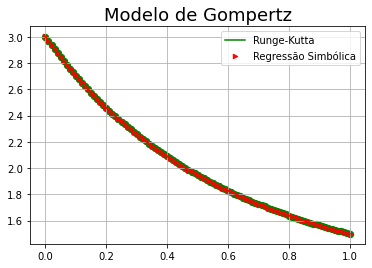

In [12]:
melhor_individuo = str(hof.items[0])
#melhor_individuo_ever = 'X0_mul(Exp(K_mul(t)))'
print(melhor_individuo)
func = toolbox.compile(expr=melhor_individuo)
Xexpr = func(T)
#func = toolbox.compile(expr=melhor_individuo_ever)
#Xbest = func(T)
fig, ax = plt.subplots(1,1)
ax.set_title('Modelo de Gompertz', size = 18)
ax.scatter(T, X, c = 'g', s = 40)
ax.plot(T, X, label = 'Runge-Kutta', c = 'g')
ax.scatter(T, Xexpr, label = 'Regressão Simbólica', marker = '>', c = 'r', s = 20)
ax.plot(T, Xexpr, c = 'r')
#ax.plot(T, Xbest, label = 'Analitica', c = '0')
ax.legend()

ax.legend()
ax.grid('--')
#plt.savefig('resultados\Resultado_Gompertz_1.png', dpi = 200)

In [13]:
def Div(left, right):
    return left / right

def Exp(x):
    return sp.exp(x)

def X0_add(x):
    return x + X0

def X0_mul(x):
    return x * X0

def X0_div(x):
    return x / X0

def X0_sub(x):
    return x - X0

def K_add(x):
    return x + K

def K_mul(x):
    return x * K

def K_div(x):
    return x / K

def k_sub(x):
    return x - K

    
new_pset = gp.PrimitiveSet("MAIN", 1)

new_pset.addPrimitive(operator.add, 2)
new_pset.addPrimitive(operator.sub, 2)
new_pset.addPrimitive(operator.mul, 2)
new_pset.addPrimitive(Div, 2)
new_pset.addPrimitive(operator.neg, 1)
new_pset.addPrimitive(sp.cos, 1)
new_pset.addPrimitive(sp.sin, 1)
new_pset.addPrimitive(Exp, 1)


new_pset.addEphemeralConstant("rand106", lambda: rd.randint(-1,1))

new_pset.renameArguments(ARG0='t')
toolbox.register("compile", gp.compile, pset=new_pset)

In [14]:
func = toolbox.compile(expr=melhor_individuo)
t = Symbol('t')
X0 = Symbol('X_0')
K = Symbol('k')

In [15]:
display(sp.expand(func(t)))

exp(exp(-t)*exp(exp(-E)*exp(exp(-1))))